# Introduction to Convolution

Convolution is a mathematical operation which mixes (or “convolves”) two functions to produce a new function representing how the shape of one is modified by the other. In the examples we will be considering, one function will represent a time-series signal and the other function will be called a “filter” (or “kernel”). The signal function generally has a long extent in time while the kernel function is relatively short in time. The convolution operation involves sliding the shorter, kernel function along the length of the signal function, multiplying these two functions together at each point (the kernel is assumed to have zero value outside of its finite extent), and summing the product of that multiplication.

The figure below shows an example of the convolution operation for a discrete signal $\bf{s}$ with signal values $s_j$ and a kernel with weights $w_i$. As the kernel slides along the signal, the multiplication and summation produces a new set of values, $c_k$, which denote the convolution of the signal with the kernel.


---

<h3><center>The Convolution Operation</center></h3>

<center><img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/Images/Week2/convolutionIntuition.svg" width=700></center>


For the discrete case, the convolution values can be computed as

$$c_j = \sum_i w_i s_{j+i-1} \text{.}$$

---
The image below shows an explicit computation of an example convolution. In this example the **kernel size** is 3 and the **stride** is 1. But the stride can be larger and simply determines the step of the convolution operation. With a stride of one, after the product and sum is computed for position, the kernel is shifted by a single cell. With a larger stride you would "hop" to the next cell as determined by the stride size.

<h3><center>Convolution Example</center><h3>
<center><img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/Images/Week2/convolutionExample.svg"></center>


Note that the above cell is using convolution to calculate a rolling average of the input signal! (Thus, this so called "windowed averaging" is just a special case of convolution!)

## Mathematical Confession

All of the above material ***technically*** describes the "cross-correlation" operation, which is extremely similar to the "convolution" operation. The only difference between these two is that in a convolution operation, you reverse the order of the elements in the kernel *before* you slide it along the signal. However, for our purposes, and to match up with some of the terminollogy used in the machine learning community, we will continue to (somewhat erroneously) call this a "convolution" operaiton.

# Writing a Convolution Function

Given the material and definitions above, we can quickly write out a function to perform the convolution operation. Let's start with some standard imports

In [ ]:
# Import the numerical packages to be used
import numpy as np

# Import plotting library and set our preferences
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
# Setup our plotting preferences
%matplotlib inline
matplotlib.rcParams['font.size'] = 16

And here, let's define a function to compute the sumation relationship from above.

In [ ]:
def convolve(signal, kernel):
    """
    Convolves the provided signal with the provided kernel

    Arguments
    ---------
    signal : numpy.ndarray, shape (N, )
        The signal to be convolved (e.g., ECG data, audio data, etc...)

    kernel : numpy.ndarray, shape (M, )
        The kernel to use in the convolution.

    Returns
    -------
    conv_signal : numpy.ndarray, shape (N-M, )
        The convolved signal.
    """
    # Count the number of elements in the signal and kernel
    N = signal.shape[0]
    M = kernel.shape[0]

    # Initialize an array to store the convolution output
    conv_signal = np.zeros(N-M, dtype=np.float)

    # Loop over each element of the signal
    for i in range(N-M):
        # Multiply the kernel by the current signal chunk
        product = kernel*signal[i:i+M]

        # Sum these multiplied to get the convolved value at this point
        conv_signal[i] = np.sum(product)
        
    return conv_signal

Let's also define a function to help us visualize the results.

In [ ]:
def plot_convolution(time, signal, kernel, label=None, ax=None):
    """
    Plots the original signal and the convolved version of the signal

    Arguments
    ---------
    time : numpy.ndarray, shape (N, )
        The array of time values at which the signal samples were obtained

    signal : numpy.ndarray, shape (N, )
        The signal to be convolved (e.g., ECG data, audio data, etc...)

    kernel : numpy.ndarray, shape (M, )
        The kernel to use in the convolution.

    signal_label : str or None, (optional), default: None
        The legend label to add for the original signal

    Returns
    -------
    fig, ax
        The figure and axes instances in which the plot was generated
    """
    # Compute the convolved signal
    conv_signal = convolve(signal, kernel)

    # Create a trimmed copy of the time array to correspond to convolved signal
    start_ind = len(kernel)//2
    neg_stop_ind = -(len(kernel) - start_ind)
    conv_time = time[start_ind:neg_stop_ind]

    # Build a new axis if one was not provided
    if ax is None:
        fig1, ax1= plt.subplots(1, 1, figsize=(10, 6))
    else:
        ax1 = ax
        fig1 = ax.get_figure()

    # Plot the original signal and the convolved version
    ax1.plot(time, signal, lw=3, label=label)
    ax1.plot(conv_time, conv_signal, lw=2, label=f'Conv. {label}')
    ax1.set_xlabel('Time (sec)')
    ax1.set_ylabel('Amplitude (arb)')
    ax1.legend(loc='upper right')

    return fig1, ax1

# Visualizing Convolution

It is a bit easier to understand what a convolution actually *does* by looking at a couple of examples.

## Top Hat Kernels

As a first example, let's consider the case of a "top hat" signal being convolved by another "top hat" signal.

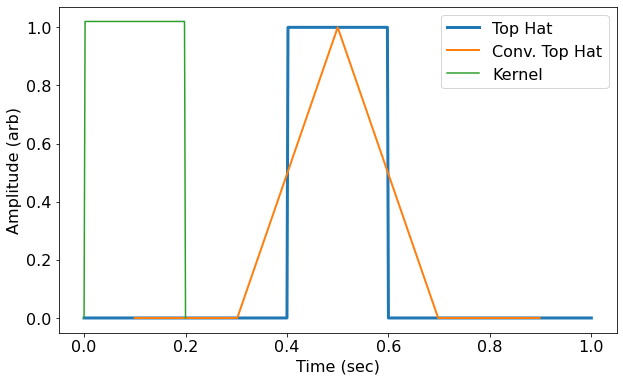

In [ ]:
# Generate a "top hat" signal
time = np.linspace(0, 1, 501)
signal = np.logical_and(time > 0.4, time < 0.6).astype(np.float)

# Define a kernel for convolution
kernel = np.ones(101)

# Let's explicitly make the far edges of this kernel zero
kernel[0] = 0
kernel[-1] = 0

# Finally, it is fairly common to "normalize" the kernel so that
# the sum of all the elements in the kernel is one.
kernel /= np.sum(kernel)

# Plot the effect of this kernel on the top hat signal
fig, ax = plot_convolution(time, signal, kernel, label='Top Hat')

# As a final step, let's visualize what the kernel looks like when it is placed
# at the very beginning of the signal. We are goin gto scale up the kernel so
# that we can actually *see* it on the y-axis.
ax.plot(time[0:kernel.size], kernel.size*kernel, label='Kernel')
leg = plt.legend()

In a sense, you can conceive of a convolution as a measure of the overlap between the non-zero parts of the kernel and the non-zero parts of the signal and the kernel at each point along the length of the signal. For example, notice how the orange curve starts at zero at the far left (where the kernel and signal do not overlap at all). As the kernel is shifted to the right, the non-zero part of the kernel starts to overlap with the non-zero part of the signal. The value of the convolved signal is equal to the area under ***both*** the kernel and the signal at each point as the kernel is shifted to the right.

The image below attempts to present this conception of the convolution as an animation.

<img src="https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif">

---

***Things to Try***
1. Experiment with different widths for the kernel
2. Do you understand what is causing each of the changes that result from these different kernels?

## Difference Kernels

In our next example, we will consider a different class of kernels which have negative values on the left and positive values on the right. The code below illustrates the effects that one of these kernels has on a pure sine-wave signal.

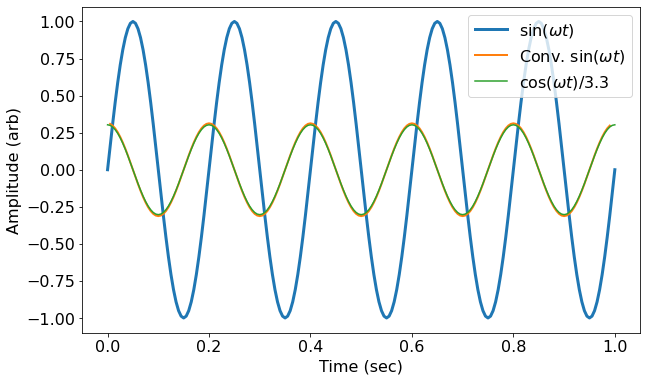

In [ ]:
# Generate a basic time-series signal
time = np.linspace(0, 1, 201)
freq = 5.0
omega = 2*np.pi*freq
signal = np.sin(omega*time)

# Re-define the kernel in case it was overwritten elsewhere
kernel = np.array([-1, 0, 1])

# Plot the effect of this kernel on the top hat signal
fig2, ax2 = plot_convolution(time, signal, kernel, label='$\sin(\omega t)$')

# Also plot the *cosine* signal with the same frequency (scaled down to
# help illustrate the point made in the "Questions for Reflection" below).
ax2.plot(time, np.cos(omega*time)/3.3, label='$\cos(\omega t)/3.3$')
leg = plt.legend()

**Questions for Reflection**

The original signal we plotted was a pure sine wave $\sin(\omega t)$ with $\omega = 2\pi \times 5$.

1. What is the derivative of $\sin(\omega t)$ with respect to $t$?
2. What does this plot imply about what the kernel in the example above is actually doing?


# Kernels a Feature Finders

Let's return to our original "top hat" signal and see what happens if we convolve this signal with our "difference kernel".

Strong edges appear to be located at [0.398 0.4   0.596 0.598] seconds


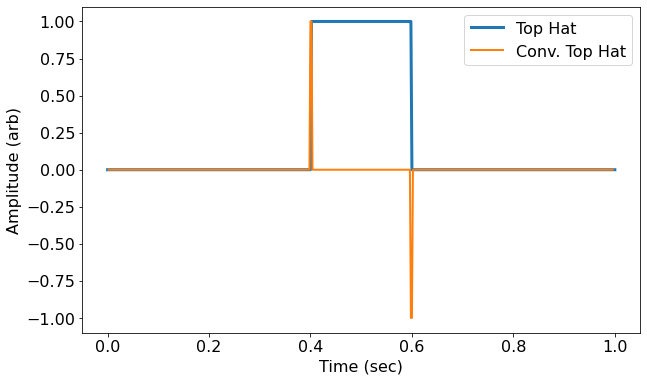

In [ ]:
# Generate a "tophat" signal
time = np.linspace(0, 1, 501)
signal = np.logical_and(time > 0.4, time < 0.6).astype(np.float)

# Define a kernel for convolution
kernel = np.array([-1, 0, 1])

# Plot the effect of this kernel on the top hat signal
fig, ax = plot_convolution(time, signal, kernel, label='Top Hat')

# Check for where this kernel produced strong results
threshold = 0.5
edges = np.abs(convolve(signal, kernel)) > threshold
edge_times = time[np.where(edges)]
print('Strong edges appear to be located at {} seconds'.format(edge_times))

This kind of a kernel appears to return very strong results (either negative or positive) wherever there is an edge. In fact, the particular example we provided is the 1-dimensional version of the [Prewit kernel](https://en.wikipedia.org/wiki/Prewitt_operator), which is a common kernel to use as an "edge detector."

This is just one example of how an appropriately designed kernel can be used to extract features from a time-series. The art and craft of designing these "feature finding kernels" is yet another case where domain expertise may come in handy. Since none of us have many years of experience in the medical field, perhaps we can figure out some other way to get good kernels for finding features. We will return to this topic at the end of the notebook.

# Smoothing Kernels
Let's consider one more example using the real ECG data we used in previous notebooks. In this example we are going to look at what happens when you convolve this noisy signal with a broad, smooth kernel, such as a [Gaussian](https://en.wikipedia.org/wiki/Gaussian_function).

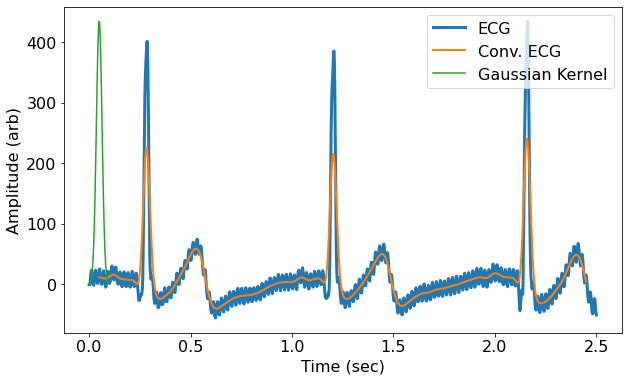

In [ ]:
# For this example let's consider the ECG time series we looked at earlier
ecg_url = 'https://raw.githubusercontent.com/BeaverWorksMedlytics2020/Data_Public/master/NotebookExampleData/Week2/ecg.txt'
signal = np.loadtxt(ecg_url, skiprows=4)
signal = signal - np.median(signal) # Center about signal median
signal = signal[0:2501]             # Just look at the first 2.5 seconds

# Generate the sample timestamps
sampling_frequency = 1000.0         # Retrieved from ecg.txt header information
time = np.arange(0, signal.size/sampling_frequency, 1.0/sampling_frequency)

# Define a kernel to examine
num_points = 101                    # Number of points in the kernel
gaus_width = 14                     # standard-deviation width of the gaussian
kernel = np.exp(-0.5*((np.arange(num_points) - num_points//2)/gaus_width)**2)
kernel = kernel/np.sum(kernel)      # Apply normalization

# Visualize the original signal and its convolution
fig, ax = plot_convolution(time, signal, kernel, label='ECG')
scaled_kernel = signal.max()*kernel/kernel.max()    # Scale for plotting
ax.plot(time[0:kernel.size], scaled_kernel, label='Gaussian Kernel')
ax.legend(loc='upper right')
plt.show()

Notice how this Gaussian kernel smooths outh all of the noise and really highlights each of the peaks which have a similar shape to the kernel. This is yet another way that convolution is used. To get a better understanding 

# Relationship to the Fourier Transform

It turns out that the convolution process has a neat relationship to the Fourier Transform. In this section, we are going to investigate that resationship. Let's start by defining a function to visualize a Fourier Transform for a signal.

In [ ]:
def plot_FT(fourier_transform, sampling_frequency, label=None, ax=None):
    """
    Plots the Fourier Transform frequency spectrum
    
    Arguments
    ---------
    fourier_transform : numpy.ndarray, shape (N, )
        The complex fourier transform values to plot

    sampling_frequency : float
        The sampling frequency used when sampling the original signal
    
    Returns
    -------
    fig, ax
        The figure and axes instances in which the plot was generated
    """
    # Generate the frequencies associated with the fourier transform values
    num_samples = len(fourier_transform)
    freqs = np.linspace(0, sampling_frequency, num_samples)

    # Build a new axis if one was not provided
    if ax is None:
        fig1, ax1= plt.subplots(1, 1, figsize=(10, 6))
    else:
        ax1 = ax
        fig1 = ax.get_figure()

    # Plot and label the fourier transform amplitude values
    ax1.plot(freqs[0:num_samples//2],
            np.abs(fourier_transform[0:num_samples//2]) * (2/num_samples),
            lw=2, label=label)
    ax1.set_ylabel("Amplitude (arb)")
    ax1.set_xlabel("Frequency (Hz)")

    return fig1, ax1

Let's examine the Fourier transforms of the ECG signal and the Gaussian kernel to get a sense of what is going on with each in the "frequency domain."

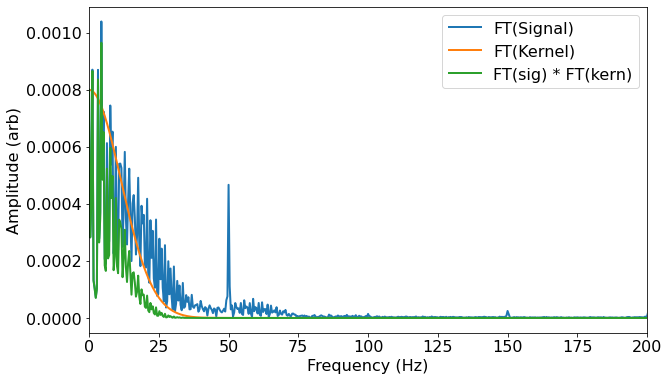

In [ ]:
# NOTE: Make sure to run the ECG example before this so that the signal and
# the apropriate kernel will already be defined.

# Apply zero-padding to our kernel so that it's the same size as our signal
kern_pad = np.pad(kernel, (signal.size - kernel.size)//2)

# Compute the fourier transforms of the signal and the padded kernel
signal_ft = np.fft.fft(signal)
kern_ft = np.fft.fft(kern_pad)
product_ft = kern_ft*signal_ft

# Visualize the fourier transform of the signal, the kernel, and the product
fig, ax = plot_FT(signal_ft/np.sum(signal), sampling_frequency,
                  label='FT(Signal)')
plot_FT(kern_ft/np.sum(kern_pad), sampling_frequency, ax=ax,
        label='FT(Kernel)')
plot_FT(product_ft/(np.sum(signal)*np.sum(kern_pad)), sampling_frequency, ax=ax,
        label='FT(sig) * FT(kern)')

# Make things pretty!
plt.xlim((0, 200))
plt.legend(loc='upper right')
plt.show()

The blue curve is showing the Fourier transform of our original signal. This should seem somewhat familiar from our previous notebooks. The orange curve is showing the Fourier transform of the Gaussian kernel. This may seem odd, but it turns out that you actually *can* create a Gaussian function by simply adding together a bunch of sine-waves, and the orange curve shows us how much amplitude to give to the sine-waves ath the corresponding frequencies in order to build up the Gaussian function we used as our kernel. Notice that this orange curve goes to zero out at frequencies above ~30 Hz. This makes sense because we don't see any *fast oscillating* components in our Gaussian kernel. (This is a tricky concept to wrap your head around, but the payoff is definitely worth it!) Finally, notice that the green curve (which was computed by multiplying the blue curve and the orange curve) has effectively the same shape as the blue curve, but it also has the higher frequencies suppressed. Thus, the signal associated with this green curve will not have any *fast oscillating* components. It will only contain the nice, slow moving parts of the original signal.

Now, here is where the interesting relationship between convolution and the Fourier transform comes in. It turns out that you can compute the convolution of a signal with a kernel using nothing be Fourier transforms (and inverse Fourier transforms).

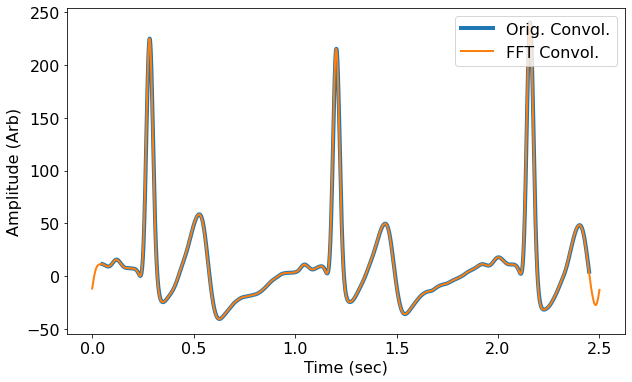

In [ ]:
# Re-compute the convolved signal using our original function
conv_signal = convolve(signal, kernel)

# Compute the convolved signal using FFT functionality
conv_signal_fft = np.real(np.fft.fftshift(np.fft.ifft(product_ft)))

# Create a trimmed copy of the time array to correspond to convolved signal
start_ind = len(kernel)//2
neg_stop_ind = -(len(kernel) - start_ind)
conv_time = time[start_ind:neg_stop_ind]

# Plot the original and FFT based convolutions
plt.figure(figsize=(10, 6))
plt.plot(conv_time, conv_signal, lw=4.0, label='Orig. Convol.')
plt.plot(time, conv_signal_fft, lw=2.0, label='FFT Convol.')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (Arb)')
plt.legend(loc='upper right')

# Force a bit of nice formatting
fig.tight_layout()

Understandably, you may have lost track of what operations were necessary to get from our starting point to this convolution. To summarize, the convolution of a signal with a kernel can be accomplished by the following steps:

1. Compute the Fourier transform of the signal

2. Pad the kernel with zeros on either side so that it is the same length as the signal

3. Compute the Fourier transform of the padded kernel

4. Multiply the two (complex) Fourier transforms together

5. Take the inverse Fourier transform of this product to get the convolved signal

# Applications for Neural Networks

By now, you have had some practice building "feature finders" for your challenge problem. There are many different ways to compute a feature, but convolution operations turn out to provide a *great* way to identify features. In this notebook alone, we have seen a few examples of how to generate a feature finding kernel.

In general, however, identifying exactly which features are going to be helpful for classification of a signal and then computing the kernels which will identify those features can be an extremely laborious process Fortunately, there is a solution!

There is a special kind of layer in a Neural Network called a "Convolutional Layer." These layers hold within them a set of kernels, and the values/shapes of these kernels can be *learned* through the training process. Thus, via deep learning, it is possible to acutally short-circuit the feature-engineering step and simply *learn* a set of kernels which extract features that turn out to be useful for classification.

Our final notebook for the week will deal with some examples of doing exactly this.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3d82bae0-f509-4ec0-92dc-a9b1bbc77ba9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>